In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io

In [3]:
mat_contents = scipy.io.loadmat(os.path.join('allFaces.mat'))
faces = mat_contents['faces']
m = int(mat_contents['m'].squeeze())
n = int(mat_contents['n'].squeeze())
nfaces = np.ndarray.flatten(mat_contents['nfaces']).astype(int)

`PCA`

In [52]:
num_people = 38
images_per_person_train = 8
image_size = m * n
trainingFaces = faces[:,:np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces,axis=1)
training_images = []
labels = []

start_idx = 0
for person_id in range(num_people):
    num_images = nfaces[person_id]
    end_idx = start_idx + num_images

    person_images = faces[:, start_idx:end_idx]
    person_train = person_images[:, :images_per_person_train]

    training_images.append(person_train)
    labels.extend([person_id] * images_per_person_train)

    start_idx = end_idx

# Build training matrix
trainingFaces = np.hstack(training_images)
labels = np.array(labels)
avgFace = np.mean(trainingFaces, axis=1)

# --- SVD ---
X = trainingFaces - avgFace[:, None]
U, S, VT = np.linalg.svd(X, full_matrices=False)

In [54]:
# --- Build face space ---
k = 100  # number of eigenfaces to keep
U_k = U[:, :k]

# --- Project training faces into eigenspace ---
train_weights = U_k.T @ (trainingFaces - avgFace[:, None])  # shape: (k, num_train_images)

# --- Define distance threshold statistically from training set ---
# Compute all pairwise distances between training images of same person
intra_class_dists = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if labels[i] == labels[j]:
            dist = np.linalg.norm(train_weights[:, i] - train_weights[:, j])
            intra_class_dists.append(dist)

intra_class_dists = np.array(intra_class_dists)
THRESHOLD = np.percentile(intra_class_dists, 80)  # you can tune this (e.g. 95%)

print(f"Distance threshold set to: {THRESHOLD:.2f}")

# --- Recognition function ---
# def recognize(query_img_flat):
#     phi = query_img_flat - avgFace
#     wq = U_k.T @ phi
#     dists = np.linalg.norm(train_weights - wq[:, None], axis=0)
#     i_best = np.argmin(dists)
#     if dists[i_best] > THRESHOLD:
#         return "unknown"
#     return labels[i_best]ص

Distance threshold set to: 14946.42


In [19]:
# for i in range(38) : 
    # for j in range(64) : print(f'{j},{recognize(faces[:, np.sum(nfaces[:i]) + j])}'  ,end=' ')
    # print ('\n')

# Testing with one unseen image per person
query_faces = []
query_labels = []

start_idx = 0
for person_id in range(num_people):
    num_images = nfaces[person_id]
    end_idx = start_idx + num_images
    person_images = faces[:, start_idx:end_idx]

    if num_images > images_per_person_train:
        query_faces.append(person_images[:, images_per_person_train])
        query_labels.append(person_id)

    start_idx = end_idx

correct = 0
for i, query_face in enumerate(query_faces):
    pred = recognize(query_face)
    if pred == query_labels[i]:
        correct += 1
    print(f"True: {query_labels[i]}, Predicted: {pred}")

print(f"\nAccuracy: {100*correct/len(query_faces):.2f}%")


True: 0, Predicted: 0
True: 1, Predicted: 1
True: 2, Predicted: 2
True: 3, Predicted: 3
True: 4, Predicted: 4
True: 5, Predicted: 5
True: 6, Predicted: 6
True: 7, Predicted: 7
True: 8, Predicted: 8
True: 9, Predicted: 9
True: 10, Predicted: 10
True: 11, Predicted: 11
True: 12, Predicted: 12
True: 13, Predicted: 13
True: 14, Predicted: 14
True: 15, Predicted: 15
True: 16, Predicted: 16
True: 17, Predicted: 17
True: 18, Predicted: 18
True: 19, Predicted: 19
True: 20, Predicted: 20
True: 21, Predicted: 21
True: 22, Predicted: 22
True: 23, Predicted: 23
True: 24, Predicted: 24
True: 25, Predicted: 25
True: 26, Predicted: 26
True: 27, Predicted: 27
True: 28, Predicted: 28
True: 29, Predicted: 29
True: 30, Predicted: 30
True: 31, Predicted: 31
True: 32, Predicted: 32
True: 33, Predicted: 33
True: 34, Predicted: 34
True: 35, Predicted: 35
True: 36, Predicted: 36
True: 37, Predicted: 37

Accuracy: 100.00%


[Denoised Image Stats] min: 7.0000, max: 234.6675, mean: 110.8903


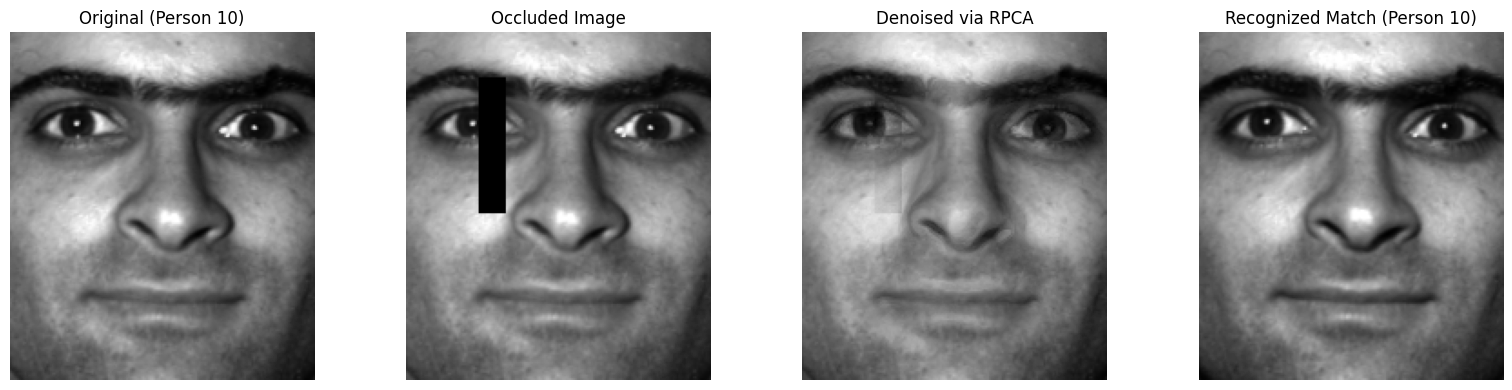

In [61]:
def inexact_alm_rpca(M, lambda_param=None, mu=None, max_iter=1000, tol=1e-7):
    m, n = M.shape
    norm_M = np.linalg.norm(M, ord='fro')
    if lambda_param is None:
        lambda_param = 1 / np.sqrt(max(m, n))
    if mu is None:
        mu = (m * n) / (4 * np.sum(np.abs(M)))

    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = M / max(np.linalg.norm(M, ord=2), np.linalg.norm(M, ord=np.inf) / lambda_param)

    for _ in range(max_iter):
        # Step 1: Low-rank update via singular value thresholding
        U, s, VT = np.linalg.svd(M - S + (1 / mu) * Y, full_matrices=False)
        s_thresh = np.maximum(s - 1 / mu, 0)
        L = (U * s_thresh) @ VT

        # Step 2: Sparse update via soft thresholding
        temp = M - L + (1 / mu) * Y
        S = np.sign(temp) * np.maximum(np.abs(temp) - lambda_param / mu, 0)

        # Step 3: Update Lagrange multipliers
        Z = M - L - S
        Y = Y + mu * Z

        if np.linalg.norm(Z, ord='fro') / norm_M < tol:
            break

    return L, S


def recognize(query_img_flat, num_support_images=60):
    idx_subset = np.random.choice(trainingFaces.shape[1], num_support_images, replace=False)
    support_faces = trainingFaces[:, idx_subset]

    # Stack with the occluded query image
    X_small = np.hstack([support_faces, query_img_flat.reshape(-1, 1)])

    # Apply RPCA
    L, S = inexact_alm_rpca(X_small)
    query_denoised_flat = L[:, -1]
    denoised_img = query_denoised_flat.reshape((m, n))
    print(f"[Denoised Image Stats] min: {denoised_img.min():.4f}, max: {denoised_img.max():.4f}, mean: {denoised_img.mean():.4f}")

    # Project into eigenspace
    phi = query_denoised_flat - avgFace
    wq = U_k.T @ phi

    # Compute distances to all training weights
    dists = np.linalg.norm(train_weights - wq[:, None], axis=0)
    i_best = np.argmin(dists)

    if dists[i_best] > THRESHOLD:
        return "unknown", query_denoised_flat, None
    return labels[i_best], query_denoised_flat, i_best


# --- Testing with visualization ---

# Choose a person and image
person_idx = 10
person_start = sum(nfaces[:person_idx])
test_image_idx = person_start + images_per_person_train  # e.g., 5th image

# Get original image
original_img_flat = faces[:, test_image_idx]
original_img = original_img_flat.reshape((m, n))

# Simulate occlusion (sunglasses)
occluded_img = original_img.copy()
occluded_img[40:55, 25:100] = 0
occluded_img_flat = occluded_img.flatten()

# Run recognition
recognized_label, denoised_img_flat, matched_idx = recognize(occluded_img_flat)

# Matched person's image
if matched_idx is not None:
    matched_img = trainingFaces[:, matched_idx].reshape((m, n))
else:
    matched_img = np.ones((m, n)) * 255  # white image for "unknown"

# Plot all images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
titles = [
    f"Original (Person {person_idx})",
    "Occluded Image",
    "Denoised via RPCA",
    f"Recognized Match (Person {recognized_label})" if matched_idx is not None else "No Match Found"
]
images = [original_img.T, occluded_img.T, denoised_img_flat.reshape((m, n)).T, matched_img.T]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [36]:
from PIL import Image

# Pick and reshape the image
person_idx = 10
image_idx = images_per_person_train  # 5th image
person_start = sum(nfaces[:person_idx])
flat_index = person_start + image_idx

img_flat = faces[:, flat_index]
img_matrix = img_flat.reshape((m, n)).T  # Transpose if image looks rotated

# Normalize and convert to uint8 for saving
img_min = img_matrix.min()
img_range = np.ptp(img_matrix)  # FIXED LINE
img_uint8 = ((img_matrix - img_min) / img_range * 255).astype(np.uint8)

# Save using PIL
pil_img = Image.fromarray(img_uint8)
save_path = "person10_img5.png"
pil_img.save(save_path)
print(f"Saved image to {save_path}")



Saved image to person10_img5.png


[Denoised Image Stats] min: 17.6352, max: 159.6204, mean: 94.7064


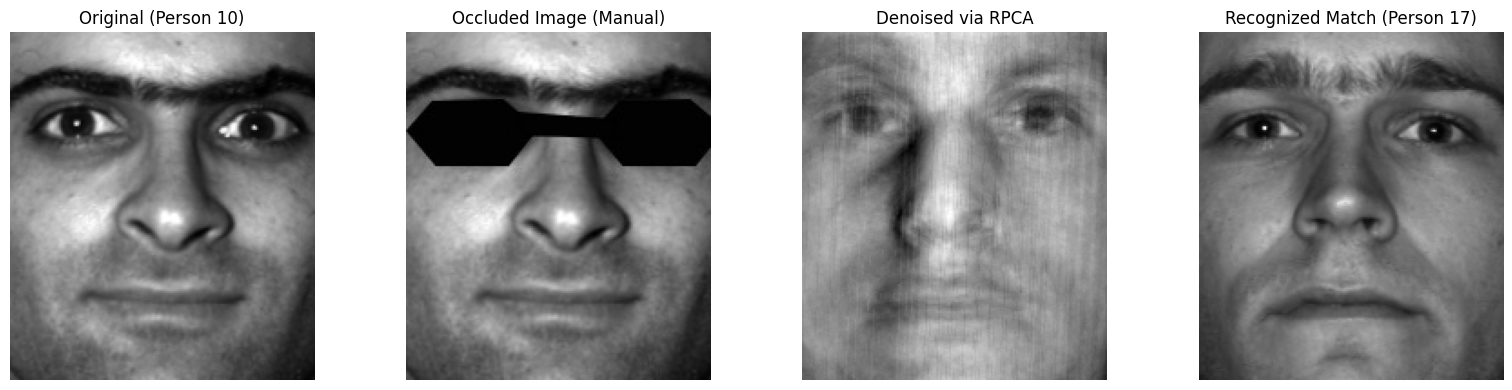

In [66]:
def recognize(query_img_flat, num_support_images=60):
    idx_subset = np.random.choice(trainingFaces.shape[1], num_support_images, replace=False)
    support_faces = trainingFaces[:, idx_subset]

    # Stack with the occluded query image
    X_small = np.hstack([support_faces, query_img_flat.reshape(-1, 1)])

    # Apply RPCA
    L, S = inexact_alm_rpca(X_small)
    query_denoised_flat = L[:, -1]

    # --- NEW: Print min, max, mean of denoised image ---
    denoised_img = query_denoised_flat.reshape((m, n))
    print(f"[Denoised Image Stats] min: {denoised_img.min():.4f}, max: {denoised_img.max():.4f}, mean: {denoised_img.mean():.4f}")

    # --- Post-processing: Add 10 intensity ---
    denoised_img += 20
    denoised_img = np.clip(denoised_img, 0, 255)  # Make sure values stay valid

    query_denoised_flat = denoised_img.flatten()

    # Project into eigenspace
    phi = query_denoised_flat - avgFace
    wq = U_k.T @ phi

    # Compute distances to all training weights
    dists = np.linalg.norm(train_weights - wq[:, None], axis=0)
    i_best = np.argmin(dists)

    if dists[i_best] > THRESHOLD:
        return "unknown", query_denoised_flat, None
    return labels[i_best], query_denoised_flat, i_best


# Load image
edited_img_path = "person10_img5.png"
edited_img = Image.open(edited_img_path).convert('L')  # Ensure grayscale

# Convert to NumPy array and flatten
edited_img_np = np.array(edited_img).T  # Transpose if needed

# --- Prepare original image for Person 10 ---
person_idx = 10
person_start = sum(nfaces[:person_idx])
test_image_idx = person_start + images_per_person_train  # 5th image of person 10

original_img_flat = faces[:, test_image_idx]
original_img = original_img_flat.reshape((m, n))

# --- Preprocess manually edited image ---
# (You already loaded this into edited_img_np from PIL image and resized/transposed correctly)

occluded_img = edited_img_np  # shape should be (m, n)
occluded_img_flat = occluded_img.T.flatten()  # Flattened in column-major order (matching rest)

# --- Run recognition ---
recognized_label, denoised_img_flat, matched_idx = recognize(occluded_img_flat,300)

# --- Get matched person's image ---
if matched_idx is not None:
    matched_img = trainingFaces[:, matched_idx].reshape((m, n))
else:
    matched_img = np.ones((m, n)) * 255  # blank image for "unknown"

# --- Plot everything ---
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

titles = [
    f"Original (Person {person_idx})",
    "Occluded Image (Manual)",
    "Denoised via RPCA",
    f"Recognized Match (Person {recognized_label})" if matched_idx is not None else "No Match Found"
]
images = [original_img.T, occluded_img.T, denoised_img_flat.reshape((m, n)).T, matched_img.T]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
